In [60]:
import pandas as pd
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
import re
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
import string
from wordcloud import STOPWORDS

## Chargement Dataset

In [61]:
df  = pd.read_pickle("df_balanced.pkl")


## Apercu des valeurs 

In [62]:
df.head()

,id,keyword,location,text,target,char_count,word_count,stopword_count,unique_word_count,stop_word_count,...,punctuation_count,hashtag_count,mention_count,clean_text,tokens,version_stop,version_stem,version_lemma,clean_location,clean_keyword
6818,9765,trapped,10 steps ahead. cloud 9,bomb head? explosive decisions dat produced mo...,1,134,21,6,20,6,...,1,0,0,bomb head explosive decisions dat produced mor...,"[bomb, head, explosive, decisions, dat, produc...",bomb head explosive decisions dat produced dea...,bomb head explos decis dat produc dead childre...,bomb head explosive decision dat produced dead...,steps ahead cloud,trapped
4842,6896,mass%20murder,"huntsville, al",okay not sure the word 'mass murder' applies d...,1,121,19,9,18,8,...,8,0,0,okay not sure the word mass murder applies dur...,"[okay, sure, word, mass, murder, applies, war,...",okay sure word mass murder applies war horrend...,okay sure word mass murder appli war horrend n...,okay sure word mass murder applies war horrend...,huntsville al,massmurder
5848,8356,ruin,garrett,like why on earth would you want anybody to be...,0,101,17,6,17,8,...,2,0,0,like why on earth would you want anybody to be...,"[like, earth, would, want, anybody, unhappy, d...",like earth would want anybody unhappy dont pur...,like earth would want anybodi unhappi dont pur...,like earth would want anybody unhappy dont pur...,garrett,ruin
1851,2661,crush,"cleveland, ohio",my woman crush wedneday goes to the beautiful ...,0,108,12,3,12,3,...,8,2,1,my woman crush wedneday goes to the beautiful,"[woman, crush, wedneday, goes, beautiful]",woman crush wedneday goes beautiful,woman crush wedneday goe beauti,woman crush wedneday go beautiful,cleveland ohio,crush
5729,8176,rescuers,washington,#news: 'many deaths' in shipwreck: rescuers ar...,1,136,18,6,18,5,...,14,1,1,many deaths in shipwreck rescuers are trying t...,"[many, deaths, shipwreck, rescuers, trying, sa...",many deaths shipwreck rescuers trying save hun...,mani death shipwreck rescuer tri save hundr mi...,many death shipwreck rescuer trying save hundr...,washington,rescuers


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4392 entries, 6818 to 2019
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4392 non-null   int64  
 1   keyword            4392 non-null   object 
 2   location           4392 non-null   object 
 3   text               4392 non-null   object 
 4   target             4392 non-null   int64  
 5   char_count         4392 non-null   int64  
 6   word_count         4392 non-null   int64  
 7   stopword_count     4392 non-null   int64  
 8   unique_word_count  4392 non-null   int64  
 9   stop_word_count    4392 non-null   int64  
 10  url_count          4392 non-null   int64  
 11  mean_word_length   4392 non-null   float64
 12  punctuation_count  4392 non-null   int64  
 13  hashtag_count      4392 non-null   int64  
 14  mention_count      4392 non-null   int64  
 15  clean_text         4392 non-null   object 
 16  tokens             4392 no

In [64]:
nb_uniques = df["clean_keyword"].nunique()  # nombre de mots-clés uniques (≠ valeurs nulles)
nb_non_nulls = df["clean_keyword"].notnull().sum()  # cellules non vides
pourcentage_remplis = nb_non_nulls / len(df) * 100

print("Nombre de mots clés uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots clés uniques : 221
Pourcentage de cellules remplies : 100.00%


In [65]:
nb_uniques = df["clean_location"].nunique()  # nombre de mots-clés uniques (≠ valeurs nulles)
nb_non_nulls = df["clean_location"].notnull().sum()  # cellules non vides
pourcentage_remplis = nb_non_nulls / len(df) * 100

print("Nombre de mots location uniques :", nb_uniques)
print(f"Pourcentage de cellules remplies : {pourcentage_remplis:.2f}%")


Nombre de mots location uniques : 2570
Pourcentage de cellules remplies : 100.00%


In [66]:
print(df.shape)

(4392, 22)


In [67]:
df.dropna(inplace=True)

## EDA


In [68]:
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

In [69]:
# Fonction pour obtenir les mots les plus fréquents
def get_top_words(series, n=10):
    words = " ".join(series).lower().split()
    words = [w for w in words if w not in ENGLISH_STOP_WORDS]
    return Counter(words).most_common(n)


# Extraction des top mots
top_words_0 = get_top_words(df_0["clean_keyword"], 50)
top_words_1 = get_top_words(df_1["clean_keyword"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Keyword (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Keyword (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Keyword (Non-catastrophe),Fréquence,Keyword (Catastrophe),Fréquence
0,ruin,22,outbreak,30
1,harm,21,wreckage,28
2,blight,21,oilspill,27
3,deluge,21,collision,26
4,armageddon,21,derailment,25
5,blewup,20,buildingsonfire,25
6,mayhem,19,evacuated,25
7,inundated,19,earthquake,24
8,fear,19,airplaneaccident,24
9,screaming,19,sandstorm,24


In [70]:
# Extraction des top mots
top_words_0 = get_top_words(df_0["clean_location"], 50)
top_words_1 = get_top_words(df_1["location"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Location (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Location (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Location (Non-catastrophe),Fréquence,Location (Catastrophe),Fréquence
0,new,102,usa,126
1,usa,99,new,80
2,york,76,ca,57
3,ca,62,united,44
4,london,53,nigeria,42
5,united,45,canada,41
6,ny,41,uk,40
7,england,40,india,34
8,uk,39,states,33
9,city,37,san,33


In [71]:
# Extraction des top mots
top_words_0 = get_top_words(df_0["clean_text"], 50)
top_words_1 = get_top_words(df_1["clean_text"], 50)

# Tableau combiné
df_top_0 = pd.DataFrame(top_words_0, columns=["Mot (Non-catastrophe)", "Fréquence"])
df_top_1 = pd.DataFrame(top_words_1, columns=["Mot (Catastrophe)", "Fréquence"])
display(pd.concat([df_top_0, df_top_1], axis=1))


,Mot (Non-catastrophe),Fréquence,Mot (Catastrophe),Fréquence
0,im,137,police,80
1,like,122,amp,75
2,just,118,people,67
3,new,108,like,66
4,amp,97,disaster,66
5,dont,70,pm,64
6,body,60,buildings,63
7,emergency,50,just,63
8,video,49,suicide,61
9,people,48,killed,60


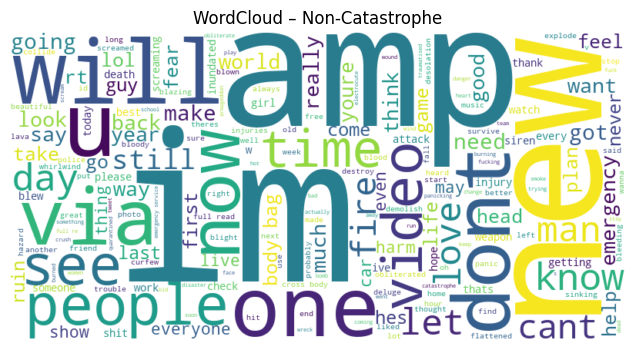

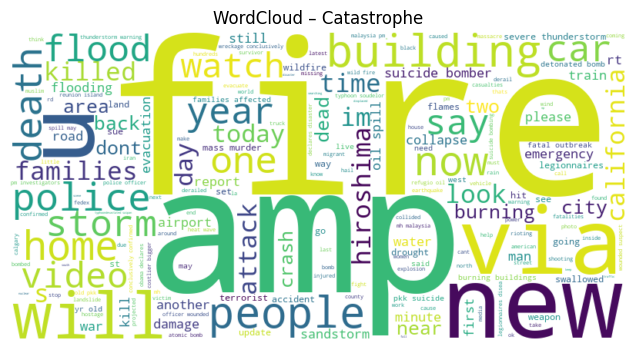

In [72]:
# Concaténer les textes par classe
text_0 = " ".join(df_0["clean_text"])
text_1 = " ".join(df_1["clean_text"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()

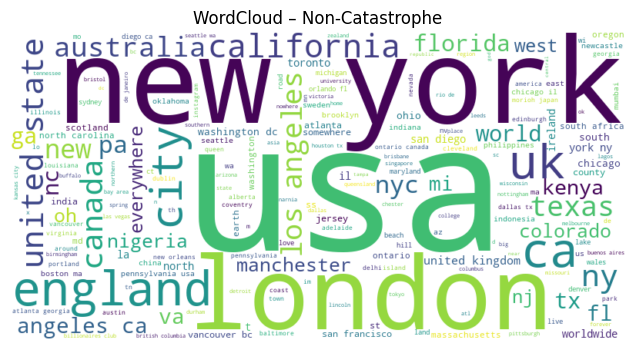

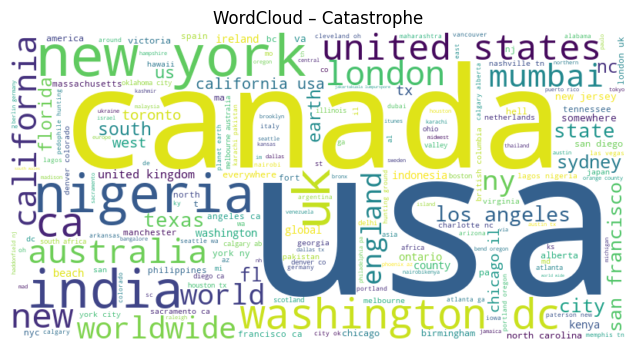

In [73]:
# Concaténer les textes par classe
text_0 = " ".join(df_0["clean_location"])
text_1 = " ".join(df_1["clean_location"])

# Générer les nuages de mots
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate(text_0)
wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate(text_1)

# Affichage du WordCloud pour target = 0
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Non-Catastrophe")
plt.show()

# Affichage du WordCloud pour target = 1
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud – Catastrophe")
plt.show()


## Analyse des features

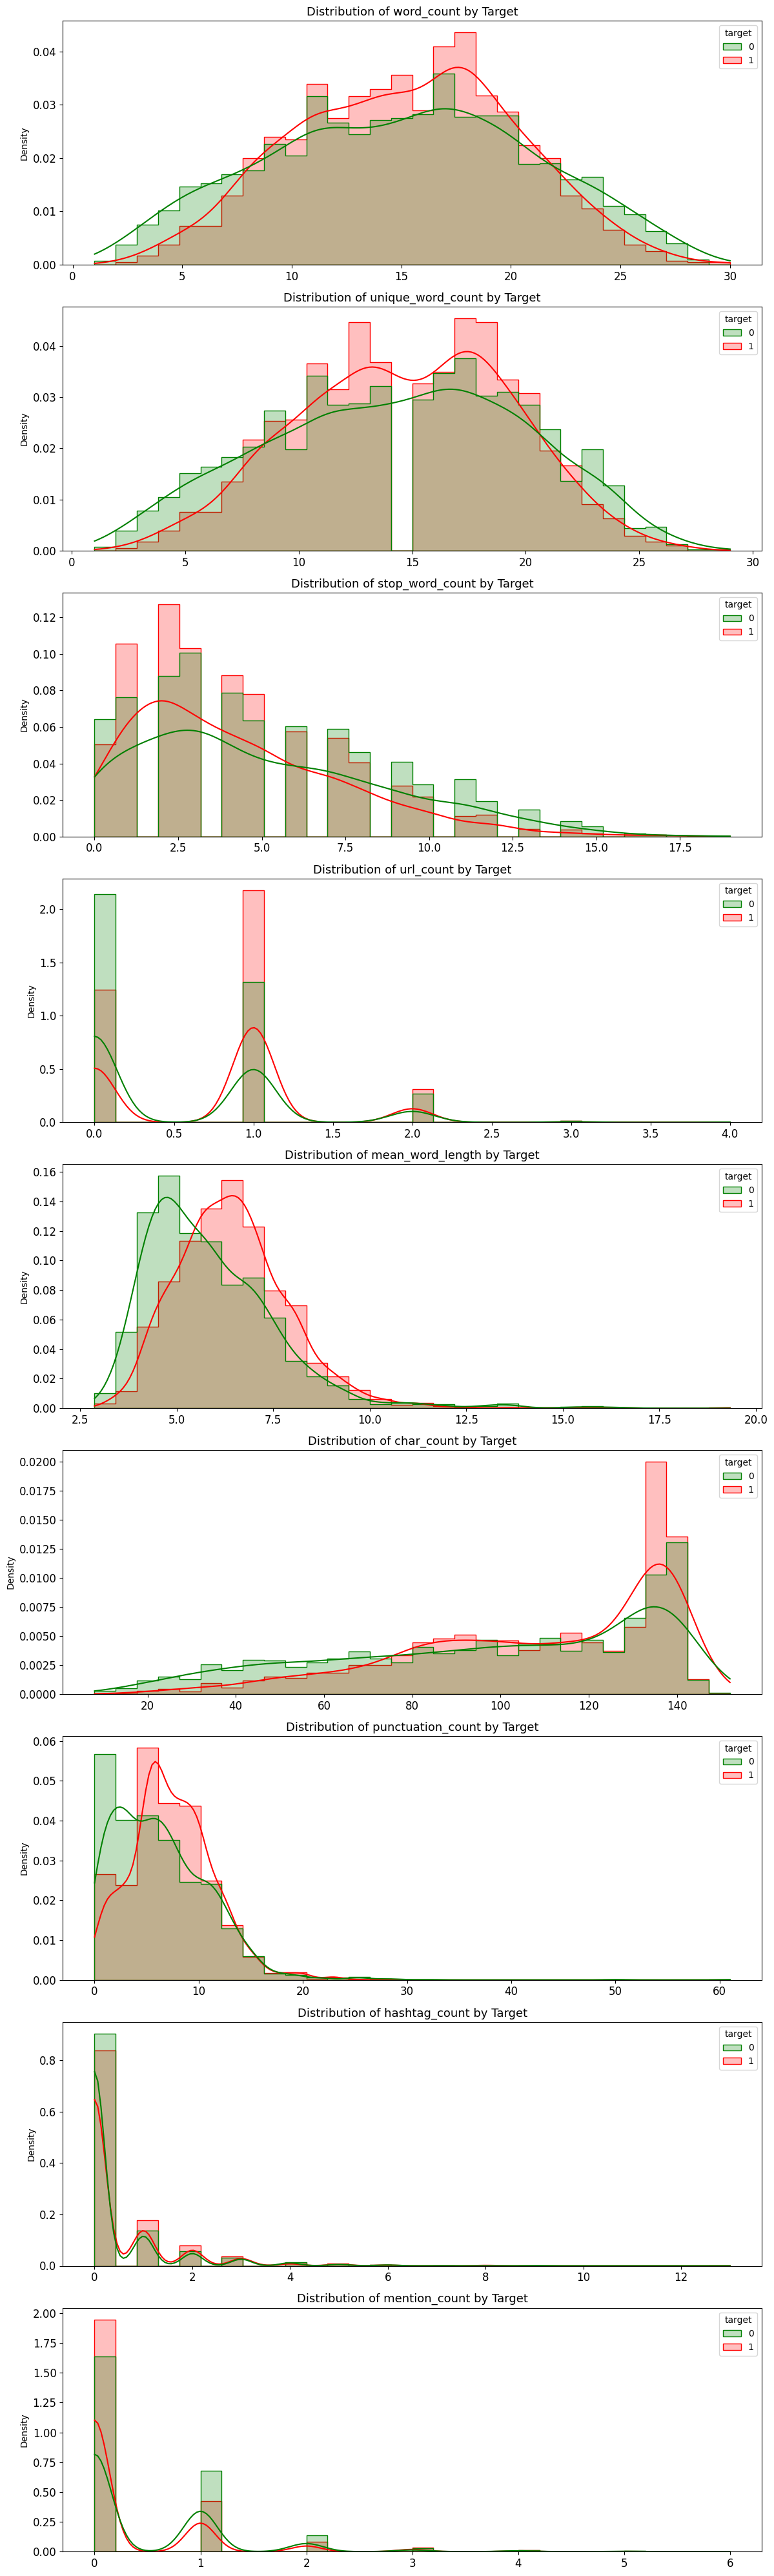

In [74]:
# Liste des features à analyser
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count',
                'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# Filtre pour les tweets liés à des catastrophes
DISASTER_TWEETS = df['target'] == 1

# Création de la figure avec sous-graphiques
fig, axes = plt.subplots(nrows=len(METAFEATURES), ncols=1, figsize=(12, 40), dpi=100)

# Pour chaque feature, on trace deux courbes : disaster vs non-disaster
for i, feature in enumerate(METAFEATURES):
    sns.histplot(data=df, x=feature, hue='target', kde=True, ax=axes[i], bins=30,
                 palette={0: "green", 1: "red"}, element="step", stat="density")
    
    axes[i].set_title(f'Distribution of {feature} by Target', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(1, 1), top_n=20):
    vec = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    X = vec.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return pd.DataFrame(sorted_words[:top_n], columns=['ngram', 'count'])

In [76]:
def plot_all_ngrams(df, target_value):
    text_data = df[df['target'] == target_value]['clean_text']

    bigrams = get_top_ngrams(text_data, ngram_range=(2, 2), top_n=20)
    trigrams = get_top_ngrams(text_data, ngram_range=(3, 3), top_n=20)
    quadgrams = get_top_ngrams(text_data, ngram_range=(4, 4), top_n=20)

    fig, axes = plt.subplots(1, 3, figsize=(22, 10))

    for ax, data, title in zip(
        axes,
        [bigrams, trigrams, quadgrams],
        ['Bigrammes', 'Trigrammes', 'Quadgrammes']
    ):
        ngram_df = pd.DataFrame(data, columns=['ngram', 'count'])
        sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
        ax.set_title(f"{title} pour target = {target_value}")
        ax.set_xlabel("Fréquence")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_d

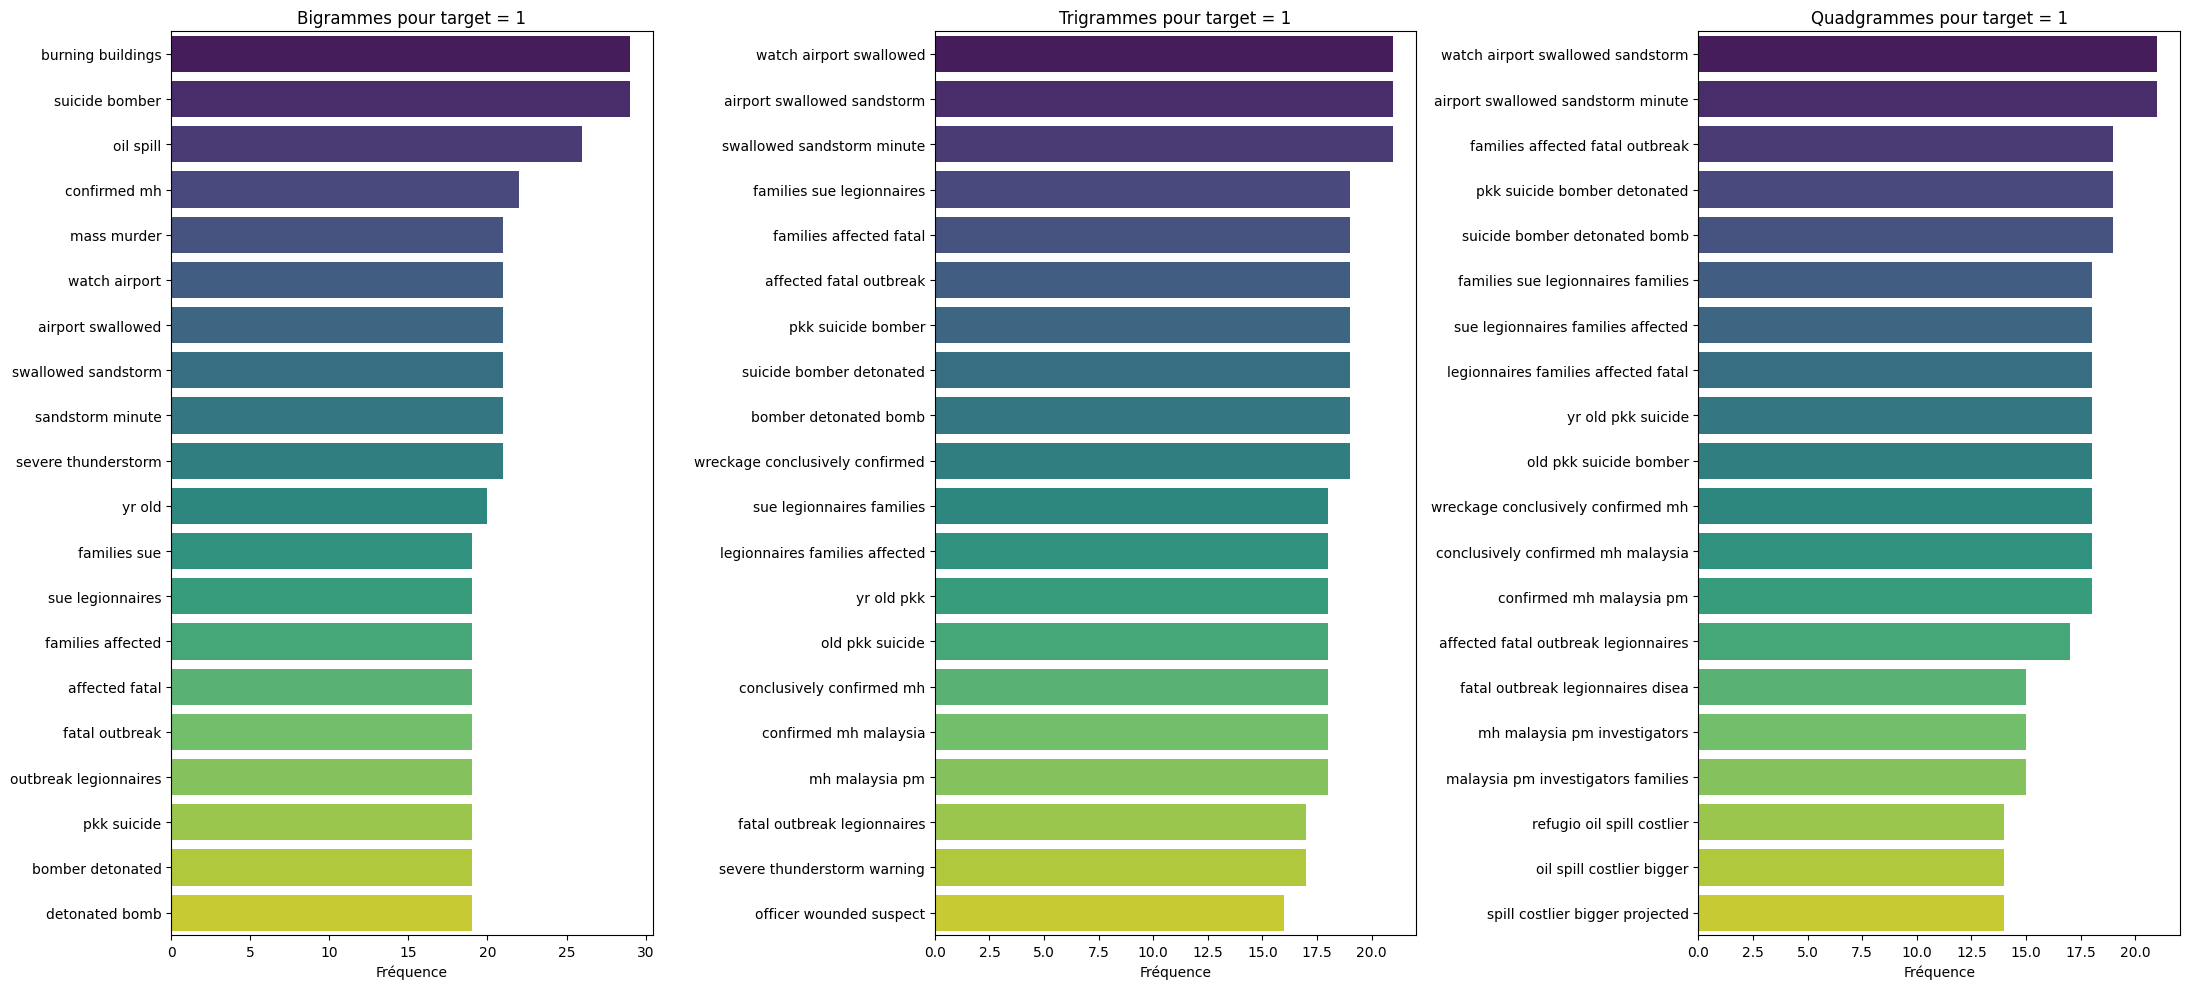

/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_df, ax=ax, palette='viridis')
/var/folders/s5/bjr8wb2s53z275k32l1crzqw0000gn/T/ipykernel_10384/3280740700.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ngram', data=ngram_d

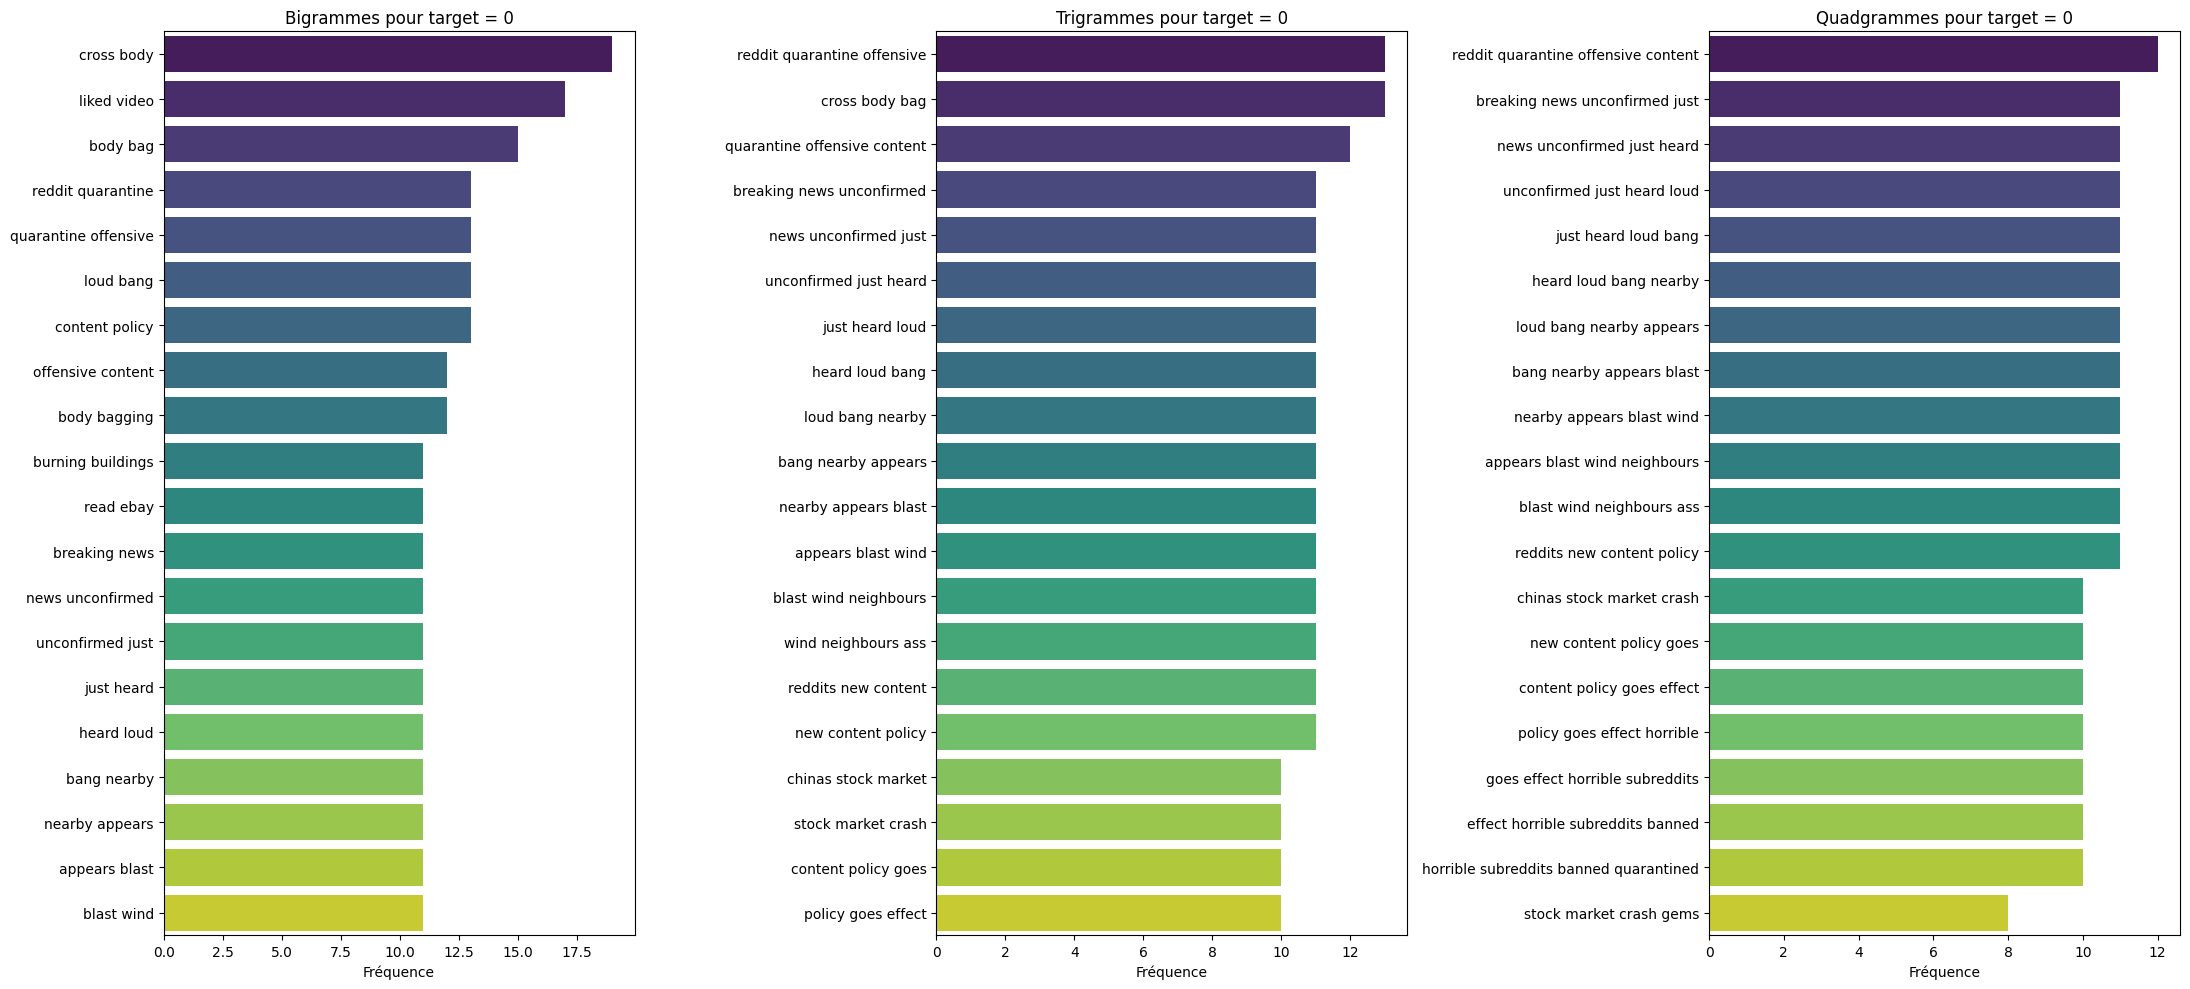

In [77]:
plot_all_ngrams(df, 1)  # Pour les tweets de catastrophe
plot_all_ngrams(df, 0)  # Pour les autres
